<a href="https://colab.research.google.com/github/ehsankarami1358/LOKA_HYDRO/blob/main/Vibration_2025_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

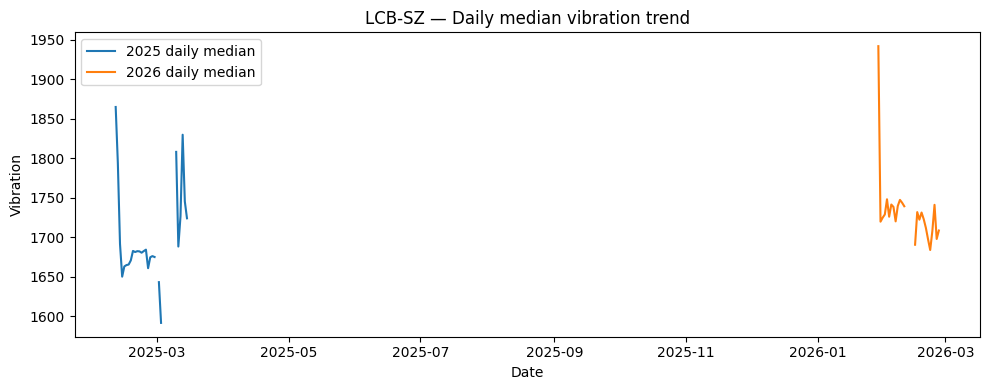

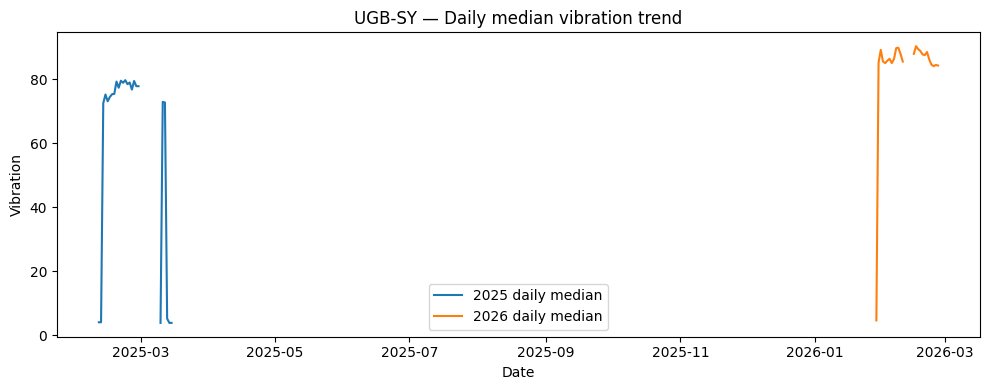

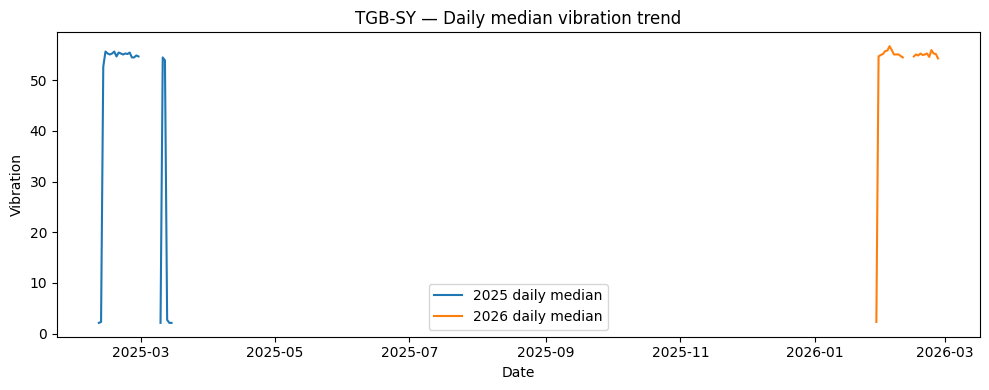

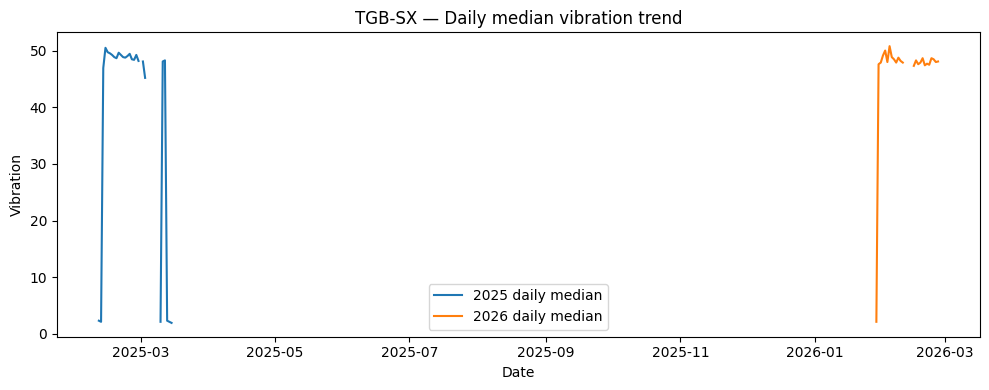

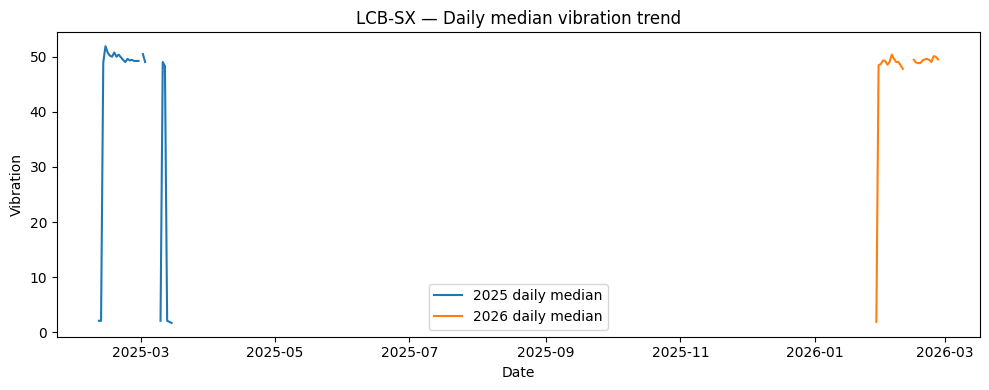

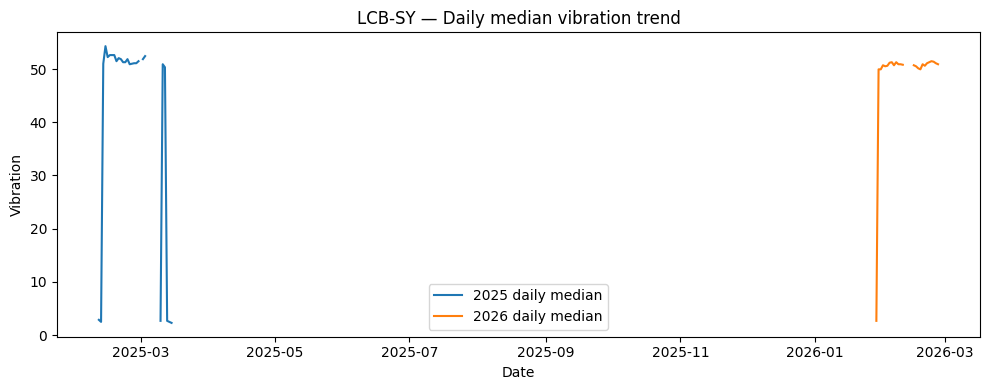

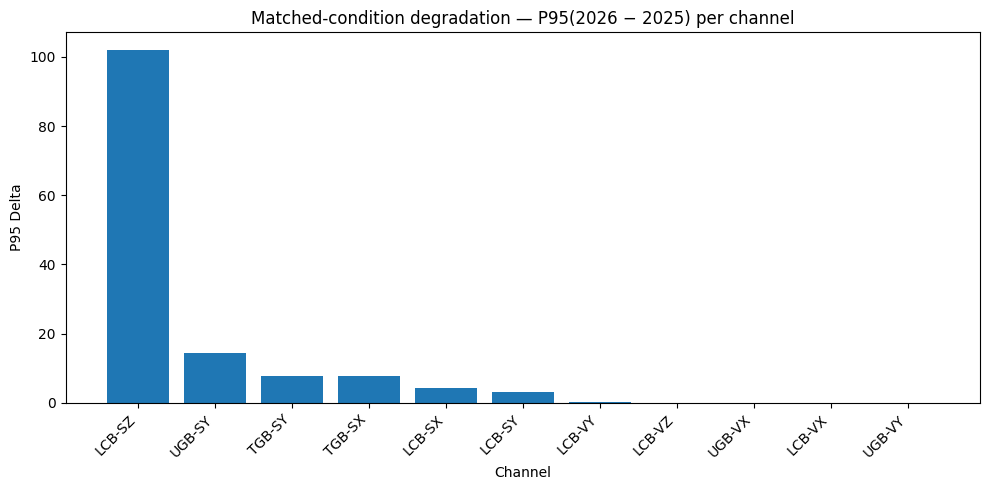

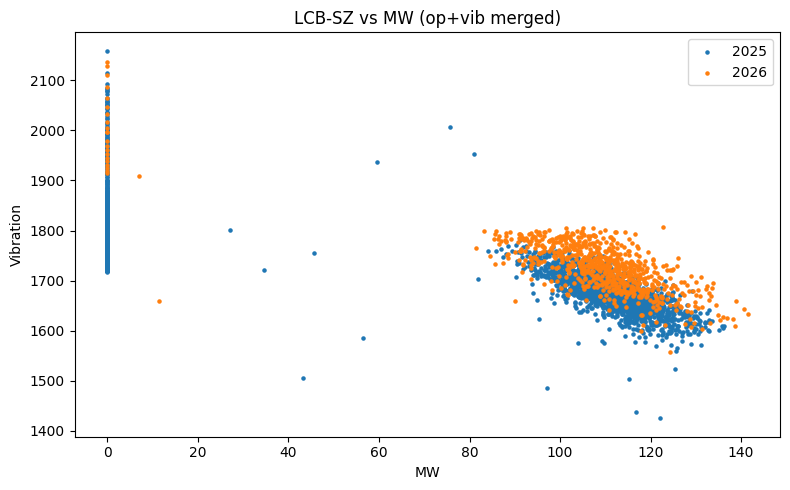

Saved merged files: Unit2_2025_op_plus_vib_1min.csv Unit2_2026_op_plus_vib_1min.csv
Saved plots: Trend_*.png, Degradation_P95_Bar.png, Scatter_*.png


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

# -----------------------------
# Inputs (edit if needed)
# -----------------------------
op_2025_path  = Path("u2_MW_OP_FL_L_10_2_2025_17_3_2025_NEW_R3.csv")
op_2026_path  = Path("u2_MW_OP_FL_L_28_1_2026_26_2_2026_R2.csv")

vib_2025_path = Path("Unit2_2025_merged_bearings_1min.csv")
vib_2026_path = Path("Unit2_2026_merged_bearings_1min.csv")

merged25_path = Path("Unit2_2025_op_plus_vib_1min.csv")
merged26_path = Path("Unit2_2026_op_plus_vib_1min.csv")

degr_path     = Path("Unit2_Matched_Degradation_2025_vs_2026.csv")

# -----------------------------
# Helpers
# -----------------------------
def find_timestamp_col(df: pd.DataFrame) -> str:
    cands = [c for c in df.columns if ("time" in c.lower()) or ("date" in c.lower())]
    return cands[0] if cands else df.columns[0]

def load_operation(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    ts_col = find_timestamp_col(df)
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.rename(columns={ts_col: "timestamp"}).dropna(subset=["timestamp"])
    return df.sort_values("timestamp")

def load_vibration(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["timestamp"]).dropna(subset=["timestamp"])
    df = df.sort_values("timestamp")
    for c in df.columns:
        if c != "timestamp":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def merge_op_vib(op: pd.DataFrame, vib: pd.DataFrame, tolerance="2min") -> pd.DataFrame:
    # Keep ALL operation rows; attach nearest vibration sample
    return pd.merge_asof(
        op.sort_values("timestamp"),
        vib.sort_values("timestamp"),
        on="timestamp",
        direction="nearest",
        tolerance=pd.Timedelta(tolerance),
    )

def detect_col(df: pd.DataFrame, keywords):
    for c in df.columns:
        name = str(c).upper()
        if any(k.upper() in name for k in keywords):
            return c
    return None

# -----------------------------
# 1) Build merged op+vib per year
# -----------------------------
op25 = load_operation(op_2025_path)
op26 = load_operation(op_2026_path)
v25  = load_vibration(vib_2025_path)
v26  = load_vibration(vib_2026_path)

m25 = merge_op_vib(op25, v25, tolerance="2min")
m26 = merge_op_vib(op26, v26, tolerance="2min")

m25.to_csv(merged25_path, index=False)
m26.to_csv(merged26_path, index=False)

# -----------------------------
# 2) Visualize degradation + vibration trends
# -----------------------------
degr = pd.read_csv(degr_path)

# vibration columns like LCB-SZ, UGB-SY, ...
vib_cols = [c for c in m26.columns if re.match(r"^(LCB|UGB|TGB)-[VS][XYZ]$", str(c))]

# top channels by p95_delta
top_n = 6
top_channels = degr.sort_values("p95_delta", ascending=False)["channel"].head(top_n).astype(str).tolist()

m25i = m25.copy()
m26i = m26.copy()
m25i["timestamp"] = pd.to_datetime(m25i["timestamp"])
m26i["timestamp"] = pd.to_datetime(m26i["timestamp"])
m25i = m25i.set_index("timestamp").sort_index()
m26i = m26i.set_index("timestamp").sort_index()

# (A) Daily median trend plots
for ch in top_channels:
    if ch not in m25i.columns or ch not in m26i.columns:
        continue
    s25 = pd.to_numeric(m25i[ch], errors="coerce").dropna()
    s26 = pd.to_numeric(m26i[ch], errors="coerce").dropna()
    if len(s25) == 0 or len(s26) == 0:
        continue

    d25 = s25.resample("1D").median()
    d26 = s26.resample("1D").median()

    plt.figure(figsize=(10, 4))
    plt.plot(d25.index, d25.values, label="2025 daily median")
    plt.plot(d26.index, d26.values, label="2026 daily median")
    plt.title(f"{ch} — Daily median vibration trend")
    plt.xlabel("Date")
    plt.ylabel("Vibration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Trend_{ch}_2025_vs_2026.png", dpi=150)
    plt.show()

# (B) Degradation bar chart (p95_delta)
plt.figure(figsize=(10, 5))
degr_sorted = degr.sort_values("p95_delta", ascending=False)
plt.bar(degr_sorted["channel"].astype(str), degr_sorted["p95_delta"].values)
plt.title("Matched-condition degradation — P95(2026 − 2025) per channel")
plt.xlabel("Channel")
plt.ylabel("P95 Delta")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("Degradation_P95_Bar.png", dpi=150)
plt.show()

# (C) Scatter plot worst channel vs MW
mw25_col = detect_col(m25, ["MW", "POWER"])
mw26_col = detect_col(m26, ["MW", "POWER"])
worst = top_channels[0] if top_channels else None

if worst and mw25_col and mw26_col:
    sub25 = m25i[[mw25_col, worst]].apply(pd.to_numeric, errors="coerce").dropna()
    sub26 = m26i[[mw26_col, worst]].apply(pd.to_numeric, errors="coerce").dropna()

    plt.figure(figsize=(8, 5))
    plt.scatter(sub25[mw25_col].values, sub25[worst].values, s=5, label="2025")
    plt.scatter(sub26[mw26_col].values, sub26[worst].values, s=5, label="2026")
    plt.title(f"{worst} vs MW (op+vib merged)")
    plt.xlabel("MW")
    plt.ylabel("Vibration")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Scatter_{worst}_vs_MW_2025_2026.png", dpi=150)
    plt.show()

print("Saved merged files:", merged25_path, merged26_path)
print("Saved plots: Trend_*.png, Degradation_P95_Bar.png, Scatter_*.png")